# Notebook: Convolutional Neural Networks

In this notebook, we present the **Convolutional Neural Networks** and its application to image recognition.

## Contents
The structure of the notebook is as follows:
* Training a convnet from scratch on a small dataset
* Using a pre-trained convnet


## Sources
<!--BOOK_INFORMATION-->

i) the [Keras tutorials](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) by Francois Chollet.

ii) Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) by Francois Chollet.

iii) [Segmentations for Flower Image Datasets and Others](http://www.robots.ox.ac.uk/~vgg/data/bicos/) by  Yuning Chai, Victor Lempitsky and Andrew Zisserman.


## Data structure

'''This script goes along the blog post
"Building powerful image classification models using very little data" from blog.keras.io.
It uses data that can be downloaded at:
http://www.robots.ox.ac.uk/~vgg/data/flowers/17/
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created flower1/, flower2/ and flower3/ subfolders inside train/ and validation/
- put the pictures in each folder
So that we have 100 training examples for each class, and 297 validation examples in total.
In summary, this is our directory structure:
```
data/
    train/
        flower1/
            image_00001.jpg            
            ...
        flower2/
            image_00252.jpg            
            ...
        flower3/
            image_00446.jpg            
            ...
    validation/
        flower1/
            image_00101.jpg            
            ...
        flower2/
            image_00352.jpg            
            ...
        flower3/
            image_00546.jpg            
            ...
```
'''



### 1. Using convnets with small datasets

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as three species of flowers "flower1", "flower2" or "flower3", in a dataset containing only 597 pictures of all three species . We will use 300 pictures for training, 297 for validation.

We will train a model from scratch on what little data we have. We will start by naively training a small convnet on our 300 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of up to 85%. 


## Building our network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 17x17 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 17x17). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 3) and a `softmax` activation. This unit will encode the probability that the network is looking at one class or the others.


In [48]:
#Firt we define the data directories
import os, shutil

#Import the libraries
from keras import layers
from keras import models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os


# The directory where we will store our dataset
base_dir = './data'
# Directories for our training and validation splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
num_classes=3;

#Declaration of the Neural Network model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))




Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 18, 18, 128)     

For our compilation step, we'll go with the `Adam` optimizer. We will use a categorical crossentropy as the loss which is the most apropiated in this case where we have a multi-class problem.

In [50]:
import tensorflow as tf
from keras import optimizers

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

## Data preprocessing

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [51]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#batch_size determines the number of images employed during the training for each gradient update (related to the weight optimization)
batch_size=10;

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical') #as we have a multi class classification

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 3 classes.
Found 297 images belonging to 3 classes.


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 10-sample large, so it will take 30 batches until we see our target of 300 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. 

In [52]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

/var/folders/42/hfpx92655qzc7q96w21ttvh00000gn/T/ipykernel_2446/2697540772.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
30/30 [==============================] - 9s 297ms/step - loss: 0.9276 - acc: 0.5500 - val_loss: 0.5137 - val_acc: 0.8451
Epoch 2/15
30/30 [==============================] - 9s 290ms/step - loss: 0.3585 - acc: 0.8867 - val_loss: 0.4637 - val_acc: 0.8249
Epoch 3/15
30/30 [==============================] - 9s 291ms/step - loss: 0.2453 - acc: 0.8933 - val_loss: 0.1865 - val_acc: 0.9327
Epoch 4/15
30/30 [==============================] - 9s 288ms/step - loss: 0.1033 - acc: 0.9800 - val_loss: 0.1549 - val_acc: 0.9428
Epoch 5/15
30/30 [==============================] - 9s 290ms/step - loss: 0.0585 - acc: 0.9900 - val_loss: 0.1204 - val_acc: 0.9596
Epoch 6/15
30/30 [==============================] - 9s 290ms/step - loss: 0.0349 - acc: 0.9967 - val_loss: 0.0878 - val_acc: 0.9697
Epoch 7/15
30/30 [==============================] - 9s 291ms/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9562
Epoch 8/15
30/30 [==============================] - 10s 320ms/step - loss: 0

Let's plot the loss and accuracy of the model over the training and validation data during training:

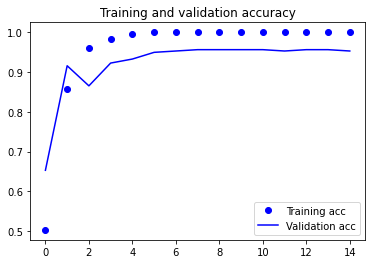

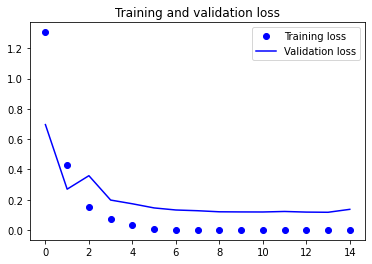

In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Not bad. The results obtained are quite good. Let's see if we can improve it using a pre-trained network

# 2. Using a pre-trained convnet

In this notebook, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). Labels available here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a.
ImageNet contains many flower class, including different species classified by only one tag=flower.  

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts.Other popular models available are: VGG, ResNet, Inception, Inception-ResNet, 
Xception...

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover only *feature extraction* but you will find a similar code for *fine-tuning* at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb. Let's start with feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of  convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![feature_extraction](./feature_extraction.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "petal shape" or "stem width"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain flower images, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Let's instantiate the VGG16 model:

In [41]:
import keras
keras.__version__

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

ImportError: cannot import name 'VGG16' from 'keras.applications' (/Users/glorelvalle/anaconda3/lib/python3.9/site-packages/keras/applications/__init__.py)

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only three classes), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [8]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

We will the first technique. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our data and using these outputs as inputs to a new model.

We will start by simply running instances of `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [40]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import sys


#Folder to include /train /validation and /test dataset. 
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#ImageDataGenerator is a Keras function to process images. In this case we will apply a simple normalization to all images.
datagen = ImageDataGenerator(rescale=1./255)




def extract_features(datagen,conv_base,directory, sample_count,batch_size,num_classes):
    
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,num_classes))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size,:] = features_batch
        labels[i * batch_size : (i + 1) * batch_size,:] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels



#Extract the features from each image using the conv base as a feature extraction.
train_features, train_labels = extract_features(datagen,conv_base,train_dir, 300, batch_size,num_classes)
validation_features, validation_labels = extract_features(datagen,conv_base,validation_dir, 297, batch_size,num_classes)

NameError: name 'conv_base' is not defined

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [10]:
#We have to reshape the features to feed the densely-connected classifier
train_features = np.reshape(train_features, (300, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (297, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [11]:
# Declaration of a densely-connected classifier with one hidden layer with 512 units and an output layer with 3 units
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))


model.compile(optimizer=optimizers.adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

#The funtion fit is used to train our classifier based on the features extracted.  We have to specify training data, number of epochs, batch size and validation data
history = model.fit(train_features, train_labels,
                    epochs=25,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 300 samples, validate on 297 samples
Epoch 1/25
300/300 [==============================] - 1s 2ms/step - loss: 1.1385 - acc: 0.4000 - val_loss: 0.7508 - val_acc: 0.8283
Epoch 2/25
300/300 [==============================] - 0s 614us/step - loss: 0.8229 - acc: 0.6300 - val_loss: 0.5918 - val_acc: 0.8923
Epoch 3/25
300/300 [==============================] - 0s 619us/step - loss: 0.6139 - acc: 0.7767 - val_loss: 0.4720 - val_acc: 0.9259
Epoch 4/25
300/300 [==============================] - 0s 613us/step - loss: 0.5100 - acc: 0.8233 - val_loss: 0.4026 - val_acc: 0.9428
Epoch 5/25
300/300 [==============================] - 0s 614us/step - loss: 0.4405 - acc: 0.8400 - val_loss: 0.3410 - val_acc: 0.9630
Epoch 6/25
300/300 [==============================] - 0s 623us/step - loss: 0.3699 - acc: 0.8900 - val_loss: 0.3227 - val_acc: 0.9562
Epoch 7/25
300/300 [==============================] - 0s 626us/step - loss: 0.3059 - acc: 0.9067 - val_loss: 0.2800 - val_acc: 0.9630
Epoch 8/25
300/300

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

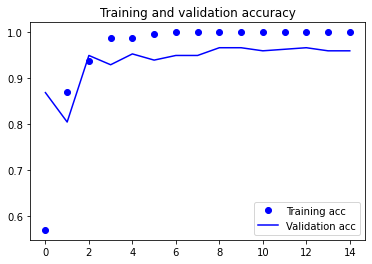

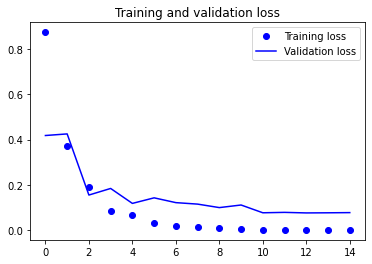

In [17]:
import matplotlib.pyplot as plt

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 97%. 